Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = 1e-2
* Optimizer = ADAM

* Our proposed: Pre-train base model with hard-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 1e-2 #tolerance for relative variation of parameters

### Load Data and preprocess

In [3]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth

print("Input shape:",X_train.shape)

Input shape: (2457, 2)


In [4]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

### Load annotations / Generate

In [61]:
from code.generate_data import SinteticData

GenerateData = SinteticData()
Tmax = 100
T_data = 10

#GenerateData.set_probas(asfile=True,file_matrix=folder+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =folder+'/synthetic/simple/groups_datasim_normal.csv')
#GenerateData.set_probas(asfile=True,file_matrix=folder+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =folder+'/synthetic/simple/groups_datasim_badMV.csv')
GenerateData.set_probas(asfile=False,file_matrix=real_conf_matrix,file_groups =aux)

real_conf_matrix = GenerateData.conf_matrix.copy()

print("New Synthetic data is being generated...",flush=True,end='')
y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

print("Accuracy of MV on train: ",np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.5274725274725275
Shape (data,annotators):  (2457, 100)
Classes:  3


In [51]:
GenerateData.prob_groups

array([0.2 , 0.45, 0.35])

In [62]:
aux = [0.15,0.4,0.45]

#### Delta Convergence criteria

In [ ]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model

In [9]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],8,1,BN=False,drop=0.2)
#model_UB = clone_model(raykarMC.base_model)

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

In [6]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [10]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_onehot = label_I.mv_labels('onehot')
mv_probas = label_I.mv_labels('probas')

ds_labels,ds_conf_M = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -17124.557179105333
2 	 -16158.932202822145 	0.4981	0.215930	0.056388
3 	 -15892.523144038392 	0.1309	0.157550	0.016487
4 	 -15726.157228804535 	0.0506	0.128238	0.010468
5 	 -15644.98675706202 	0.0564	0.090588	0.005161
6 	 -15609.433867457952 	0.0489	0.074043	0.002272
7 	 -15590.955656399563 	0.0369	0.059340	0.001184
8 	 -15580.343477364235 	0.0278	0.041804	0.000681
9 	 -15573.846897912204 	0.0214	0.025982	0.000417
10 	 -15569.898070990646 	0.0167	0.018036	0.000254
11 	 -15567.552574906822 	0.0130	0.012966	0.000151
12 	 -15566.15372050788 	0.0100	0.009616	0.000090
Class marginals
[0.34 0.34 0.32]


In [15]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.7905759162303665
ACC D&S on train: 0.9943280977312391


In [11]:
model_mvsoft = MLP_Keras(Xstd_train.shape[1:],mv_probas.shape[1],8,1,BN=False,drop=0.2)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over soft-MV")

Trained model over soft-MV


In [12]:
model_mvhard = MLP_Keras(Xstd_train.shape[1:],mv_onehot.shape[1],8,1,BN=False,drop=0.2)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over hard-MV")

Trained model over hard-MV


In [13]:
model_ds = MLP_Keras(Xstd_train.shape[1:],ds_labels.shape[1],8,1,BN=False,drop=0.2)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over D&S")

Trained model over D&S


In [63]:
from code.baseline import RaykarMC

#get representation needed for Raykar
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') 

### Raykar Model (joint predict model)

In [11]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 2.05 sec)	logL: -19204.592	
Iter 2/50 
M step: done,  E step: done //  (in 0.24 sec)	logL: -17826.641	Tol1: 0.07175	Tol2: 0.26210	
Iter 3/50 
M step: done,  E step: done //  (in 0.17 sec)	logL: -17345.211	Tol1: 0.02701	Tol2: 0.12063	
Iter 4/50 
M step: done,  E step: done //  (in 0.18 sec)	logL: -17088.066	Tol1: 0.01483	Tol2: 0.06843	
Iter 5/50 
M step: done,  E step: done //  (in 0.15 sec)	logL: -16907.961	Tol1: 0.01054	Tol2: 0.03040	
Iter 6/50 
M step: done,  E step: done //  (in 0.19 sec)	logL: -16751.262	Tol1: 0.00927	Tol2: 0.01243	
Iter 7/50 
M step: done,  E step: done //  (in 0.17 sec)	logL: -16604.973	Tol1: 0.00873	Tol2: 0.00521	
Finished training!


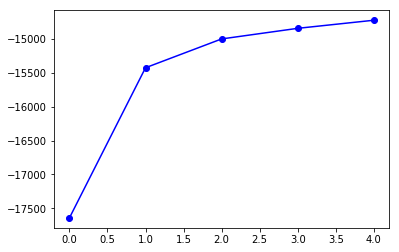

In [37]:
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.show()

In [64]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
#raykarMC.define_model("keras_shallow") 
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

logL_hists,i = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 10.32 sec)	logL: -16581.754	
Iter 2/50 
M step: done,  E step: done //  (in 0.39 sec)	logL: -15635.362	Tol1: 0.05707	Tol2: 0.30886	
Iter 3/50 
M step: done,  E step: done //  (in 0.39 sec)	logL: -15252.104	Tol1: 0.02451	Tol2: 0.08829	
Iter 4/50 
M step: done,  E step: done //  (in 0.38 sec)	logL: -14919.876	Tol1: 0.02178	Tol2: 0.08965	
Iter 5/50 
M step: done,  E step: done //  (in 0.39 sec)	logL: -14681.537	Tol1: 0.01597	Tol2: 0.07080	
Iter 6/50 
M step: done,  E step: done //  (in 0.39 sec)	logL: -14512.580	Tol1: 0.01151	Tol2: 0.04541	
Iter 7/50 
M step: done,  E step: done //  (in 0.36 sec)	logL: -14382.729	Tol1: 0.00895	Tol2: 0.02619	
Iter 8/50 
M step: done,  E step: done //  (in 0.37 sec)	logL: -14270.559	Tol1: 0.00780	Tol2: 0.01524	
Iter 9/50 
M step: done,  E step: done //  (in 0.37 sec)	logL: -14172.176	Tol1: 0.006

M step: done,  E step: done //  (in 0.37 sec)	logL: -14629.229	Tol1: 0.00881	Tol2: 0.03021	
Iter 8/50 
M step: done,  E step: done //  (in 0.36 sec)	logL: -14520.148	Tol1: 0.00746	Tol2: 0.01845	
Iter 9/50 
M step: done,  E step: done //  (in 0.37 sec)	logL: -14419.844	Tol1: 0.00691	Tol2: 0.01132	
Iter 10/50 
M step: done,  E step: done //  (in 0.40 sec)	logL: -14326.294	Tol1: 0.00649	Tol2: 0.00785	
Finished training!
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 10.29 sec)	logL: -16751.840	
Iter 2/50 
M step: done,  E step: done //  (in 0.35 sec)	logL: -15683.053	Tol1: 0.06380	Tol2: 0.33814	
Iter 3/50 
M step: done,  E step: done //  (in 0.37 sec)	logL: -15231.835	Tol1: 0.02877	Tol2: 0.12215	
Iter 4/50 
M step: done,  E step: done //  (in 0.36 sec)	logL: -14977.863	Tol1: 0.01667	Tol2: 0.09223	
Iter 5/50 
M step: done,  E step: done //  (in 0.37 sec)	logL: -14842.404	Tol1: 0.00904	Tol2: 0.05468	
Iter 6/50 
M 

M step: done,  E step: done //  (in 0.39 sec)	logL: -14012.277	Tol1: 0.00624	Tol2: 0.01627	
Iter 7/50 
M step: done,  E step: done //  (in 0.40 sec)	logL: -13934.940	Tol1: 0.00552	Tol2: 0.00806	
Finished training!
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 10.85 sec)	logL: -16202.045	
Iter 2/50 
M step: done,  E step: done //  (in 0.38 sec)	logL: -15369.284	Tol1: 0.05140	Tol2: 0.35004	
Iter 3/50 
M step: done,  E step: done //  (in 0.38 sec)	logL: -15104.760	Tol1: 0.01721	Tol2: 0.06773	
Iter 4/50 
M step: done,  E step: done //  (in 0.38 sec)	logL: -14881.156	Tol1: 0.01480	Tol2: 0.06204	
Iter 5/50 
M step: done,  E step: done //  (in 0.37 sec)	logL: -14704.643	Tol1: 0.01186	Tol2: 0.05395	
Iter 6/50 
M step: done,  E step: done //  (in 0.37 sec)	logL: -14572.191	Tol1: 0.00901	Tol2: 0.04003	
Iter 7/50 
M step: done,  E step: done //  (in 0.40 sec)	logL: -14469.012	Tol1: 0.00708	Tol2: 0.02773	
Iter 8/50 
M s

### Our Proposed

In [65]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs_categorical,"repeat")
#r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[12  0  3]
 [ 1  5  8]
 [ 4  1  8]
 ...
 [ 6  0  6]
 [ 7  1  3]
 [ 8  0  2]]
shape: (2457, 3)


In [66]:
%%time

#pre analysis
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Bayesian gaussian mixture say is 3 clusters 
DBSCAN say is 1 clusters
Affinity Propagation say is 4 clusters
Annotators PCA of annotations shape:  (100, 4)
Normalized entropy (0-1) of repeats annotations: 0.5791862654773787
CPU times: user 1.93 s, sys: 346 ms, total: 2.28 s
Wall time: 2.21 s


In [83]:
from sklearn.decomposition import TruncatedSVD


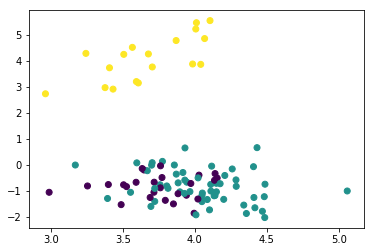

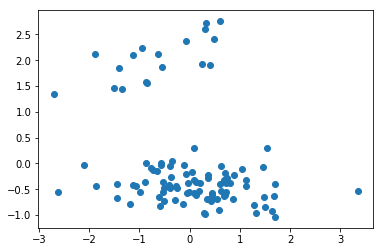

In [119]:
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c=groups_annot.argmax(axis=1))
plt.show()

std = StandardScaler()
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

In [67]:
M_seted = 3

In [68]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=5,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture1.lambda_random = False #lambda=1     
logL_hists,i_r = gMixture1.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.000764 mins
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 10.95 sec)	logL: -23512.680	
Iter 2/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -23163.547	Tol1: 0.01485	Tol2: 0.16906	Tol3: 0.03442	
Iter 3/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -22914.905	Tol1: 0.01073	Tol2: 0.11063	Tol3: 0.00790	
Iter 4/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -22634.753	Tol1: 0.01223	Tol2: 0.10248	Tol3: 0.00396	
Iter 5/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -22326.803	Tol1: 0.01361	Tol2: 0.09988	Tol3: 0.00343	
Iter 6/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -21996.231	Tol1: 0.01481	Tol2: 0.10089	Tol3: 0.00346	
Iter 7/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -21656.757	Tol1: 0.01

M step: done,  E step: done //  (in 0.34 sec)	logL: -19529.012	Tol1: 0.00246	Tol2: 0.03824	Tol3: 0.00260	
Iter 19/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -19492.330	Tol1: 0.00188	Tol2: 0.03672	Tol3: 0.00259	
Iter 20/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -19461.553	Tol1: 0.00158	Tol2: 0.03141	Tol3: 0.00245	
Iter 21/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -19433.419	Tol1: 0.00145	Tol2: 0.03536	Tol3: 0.00286	
Iter 22/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -19406.075	Tol1: 0.00141	Tol2: 0.03088	Tol3: 0.00250	
Iter 23/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -19378.760	Tol1: 0.00141	Tol2: 0.02886	Tol3: 0.00205	
Iter 24/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -19358.378	Tol1: 0.00105	Tol2: 0.03308	Tol3: 0.00239	
Iter 25/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -19343.105	Tol1: 0.00079	Tol2: 0.03252	Tol3: 0.00245	
Iter 26/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -19332.852	T

M step: done,  E step: done //  (in 0.34 sec)	logL: -19471.282	Tol1: 0.00559	Tol2: 0.06330	Tol3: 0.00262	
Iter 20/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -19392.032	Tol1: 0.00407	Tol2: 0.05558	Tol3: 0.00229	
Iter 21/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -19332.890	Tol1: 0.00305	Tol2: 0.04842	Tol3: 0.00202	
Iter 22/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -19291.389	Tol1: 0.00215	Tol2: 0.04308	Tol3: 0.00221	
Iter 23/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -19257.876	Tol1: 0.00174	Tol2: 0.03861	Tol3: 0.00262	
Iter 24/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -19232.923	Tol1: 0.00130	Tol2: 0.03309	Tol3: 0.00233	
Iter 25/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -19208.251	Tol1: 0.00128	Tol2: 0.02794	Tol3: 0.00169	
Iter 26/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -19184.336	Tol1: 0.00125	Tol2: 0.02754	Tol3: 0.00233	
Iter 27/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -19168.778	T

M step: done,  E step: done //  (in 0.37 sec)	logL: -19185.497	Tol1: 0.00055	Tol2: 0.02784	Tol3: 0.00325	
Iter 29/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -19175.982	Tol1: 0.00050	Tol2: 0.02559	Tol3: 0.00269	
Iter 30/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -19171.191	Tol1: 0.00025	Tol2: 0.02479	Tol3: 0.00211	
Iter 31/50
M step: done,  E step: done //  (in 0.40 sec)	logL: -19161.069	Tol1: 0.00053	Tol2: 0.02454	Tol3: 0.00306	
Iter 32/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -19158.158	Tol1: 0.00015	Tol2: 0.02367	Tol3: 0.00213	
Iter 33/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -19153.779	Tol1: 0.00023	Tol2: 0.02320	Tol3: 0.00230	
Iter 34/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -19148.191	Tol1: 0.00029	Tol2: 0.02211	Tol3: 0.00311	
Iter 35/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -19142.682	Tol1: 0.00029	Tol2: 0.02177	Tol3: 0.00297	
Iter 36/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -19135.072	T

M step: done,  E step: done //  (in 0.34 sec)	logL: -19615.954	Tol1: 0.00037	Tol2: 0.01901	Tol3: 0.00021	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 12.11 sec)	logL: -22926.913	
Iter 2/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -22525.958	Tol1: 0.01749	Tol2: 0.19305	Tol3: 0.01803	
Iter 3/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -22197.061	Tol1: 0.01460	Tol2: 0.13632	Tol3: 0.00261	
Iter 4/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -21862.225	Tol1: 0.01508	Tol2: 0.11819	Tol3: 0.00297	
Iter 5/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -21513.069	Tol1: 0.01597	Tol2: 0.11151	Tol3: 0.00328	
Iter 6/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -21169.940	Tol1: 0.01595	Tol2: 0.10844	Tol3: 0.00331	
Iter 7/50
M step: done,  E step: done //  (in 0.

M step: done,  E step: done //  (in 13.27 sec)	logL: -22586.733	
Iter 2/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -22158.414	Tol1: 0.01896	Tol2: 0.21043	Tol3: 0.00212	
Iter 3/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -21753.973	Tol1: 0.01825	Tol2: 0.16128	Tol3: 0.00407	
Iter 4/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -21363.456	Tol1: 0.01795	Tol2: 0.14522	Tol3: 0.00338	
Iter 5/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -20995.235	Tol1: 0.01724	Tol2: 0.13619	Tol3: 0.00243	
Iter 6/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -20666.055	Tol1: 0.01568	Tol2: 0.12957	Tol3: 0.00132	
Iter 7/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -20384.702	Tol1: 0.01361	Tol2: 0.12212	Tol3: 0.00099	
Iter 8/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -20146.746	Tol1: 0.01167	Tol2: 0.11321	Tol3: 0.00133	
Iter 9/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -19952.784	Tol1: 0.00963	Tol2: 0.10304	Tol3: 0.00188	
Iter 10

M step: done,  E step: done //  (in 0.33 sec)	logL: -19360.234	Tol1: 0.00126	Tol2: 0.02771	Tol3: 0.00141	
Iter 30/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -19341.318	Tol1: 0.00098	Tol2: 0.02819	Tol3: 0.00105	
Iter 31/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -19321.817	Tol1: 0.00101	Tol2: 0.02791	Tol3: 0.00142	
Iter 32/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -19302.796	Tol1: 0.00098	Tol2: 0.02801	Tol3: 0.00164	
Iter 33/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -19284.701	Tol1: 0.00094	Tol2: 0.02800	Tol3: 0.00113	
Iter 34/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -19268.913	Tol1: 0.00082	Tol2: 0.02781	Tol3: 0.00081	
Iter 35/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -19250.456	Tol1: 0.00096	Tol2: 0.02741	Tol3: 0.00116	
Iter 36/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -19237.569	Tol1: 0.00067	Tol2: 0.02874	Tol3: 0.00108	
Iter 37/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -19226.058	T

M step: done,  E step: done //  (in 0.34 sec)	logL: -19045.935	Tol1: 0.00017	Tol2: 0.03541	Tol3: 0.00099	
Iter 32/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -19040.996	Tol1: 0.00026	Tol2: 0.03032	Tol3: 0.00117	
Iter 33/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -19033.323	Tol1: 0.00040	Tol2: 0.03274	Tol3: 0.00123	
Iter 34/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -19029.020	Tol1: 0.00023	Tol2: 0.03106	Tol3: 0.00077	
Iter 35/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -19026.956	Tol1: 0.00011	Tol2: 0.03037	Tol3: 0.00111	
Iter 36/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -19022.027	Tol1: 0.00026	Tol2: 0.02737	Tol3: 0.00111	
Iter 37/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -19014.463	Tol1: 0.00040	Tol2: 0.02758	Tol3: 0.00114	
Iter 38/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -19011.327	Tol1: 0.00016	Tol2: 0.02468	Tol3: 0.00143	
Iter 39/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -19006.424	T

M step: done,  E step: done //  (in 0.33 sec)	logL: -23223.782	Tol1: 0.01075	Tol2: 0.08965	Tol3: 0.00371	
Iter 4/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -22953.166	Tol1: 0.01165	Tol2: 0.08047	Tol3: 0.00246	
Iter 5/50
M step: done,  E step: done //  (in 0.39 sec)	logL: -22663.648	Tol1: 0.01261	Tol2: 0.07909	Tol3: 0.00220	
Iter 6/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -22371.920	Tol1: 0.01287	Tol2: 0.08005	Tol3: 0.00200	
Iter 7/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -22090.760	Tol1: 0.01257	Tol2: 0.08125	Tol3: 0.00171	
Iter 8/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -21824.076	Tol1: 0.01207	Tol2: 0.08210	Tol3: 0.00142	
Iter 9/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -21573.931	Tol1: 0.01146	Tol2: 0.08271	Tol3: 0.00142	
Iter 10/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -21349.040	Tol1: 0.01042	Tol2: 0.08331	Tol3: 0.00194	
Iter 11/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -21150.018	Tol1: 0

M step: done,  E step: done //  (in 0.36 sec)	logL: -19247.675	Tol1: 0.00171	Tol2: 0.03267	Tol3: 0.00351	
Iter 25/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -19220.043	Tol1: 0.00144	Tol2: 0.03308	Tol3: 0.00401	
Iter 26/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -19193.244	Tol1: 0.00139	Tol2: 0.03204	Tol3: 0.00383	
Iter 27/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -19172.554	Tol1: 0.00108	Tol2: 0.03140	Tol3: 0.00377	
Iter 28/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -19150.749	Tol1: 0.00114	Tol2: 0.02952	Tol3: 0.00356	
Iter 29/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -19132.769	Tol1: 0.00094	Tol2: 0.02940	Tol3: 0.00313	
Iter 30/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -19118.128	Tol1: 0.00077	Tol2: 0.02804	Tol3: 0.00303	
Iter 31/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -19106.016	Tol1: 0.00063	Tol2: 0.02712	Tol3: 0.00284	
Iter 32/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -19095.961	T

M step: done,  E step: done //  (in 0.33 sec)	logL: -18942.475	Tol1: 0.00031	Tol2: 0.02080	Tol3: 0.00293	
Iter 29/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -18937.101	Tol1: 0.00028	Tol2: 0.02010	Tol3: 0.00256	
Iter 30/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -18933.134	Tol1: 0.00021	Tol2: 0.01926	Tol3: 0.00227	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 14.31 sec)	logL: -23389.770	
Iter 2/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -23081.082	Tol1: 0.01320	Tol2: 0.15527	Tol3: 0.02298	
Iter 3/50
M step: done,  E step: done //  (in 0.44 sec)	logL: -22795.102	Tol1: 0.01239	Tol2: 0.11598	Tol3: 0.00300	
Iter 4/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -22485.818	Tol1: 0.01357	Tol2: 0.10725	Tol3: 0.00109	
Iter 5/50
M step: done,  E step: done //  (in 

In [13]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=5,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture2.lambda_random = True #lambda random
logL_hists,i_r = gMixture2.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.000761 mins
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.2657747  0.57815886 0.918425  ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 3.18 sec)	logL: -24742.341	
Iter 2/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24394.494	Tol1: 0.01406	Tol2: 0.18024	Tol3: 0.02630	
Iter 3/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24172.271	Tol1: 0.00911	Tol2: 0.08425	Tol3: 0.00508	
Iter 4/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23952.928	Tol1: 0.00907	Tol2: 0.06283	Tol3: 0.00336	
Iter 5/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23703.542	Tol1: 0.01041	Tol2: 0.05498	Tol3: 0.00703	
Iter 6/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23418.111	Tol1: 0.01204	Tol2: 0.05760	Tol3: 0.00949	
Iter 7/50
M step: done,  E step: done //  (in 0.25 sec)	logL

M step: done,  E step: done //  (in 0.26 sec)	logL: -20125.217	Tol1: 0.00454	Tol2: 0.05184	Tol3: 0.00249	
Iter 16/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20052.349	Tol1: 0.00362	Tol2: 0.04604	Tol3: 0.00301	
Iter 17/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19992.909	Tol1: 0.00296	Tol2: 0.04479	Tol3: 0.00374	
Iter 18/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19943.493	Tol1: 0.00247	Tol2: 0.04276	Tol3: 0.00329	
Iter 19/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19901.010	Tol1: 0.00213	Tol2: 0.04114	Tol3: 0.00432	
Iter 20/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19865.219	Tol1: 0.00180	Tol2: 0.03708	Tol3: 0.00437	
Iter 21/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19836.717	Tol1: 0.00143	Tol2: 0.03601	Tol3: 0.00449	
Iter 22/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -19809.572	Tol1: 0.00137	Tol2: 0.02987	Tol3: 0.00450	
Iter 23/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19784.688	T

M step: done,  E step: done //  (in 0.24 sec)	logL: -20541.141	Tol1: 0.00517	Tol2: 0.04204	Tol3: 0.00532	
Iter 14/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20449.169	Tol1: 0.00448	Tol2: 0.03615	Tol3: 0.00418	
Iter 15/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20370.067	Tol1: 0.00387	Tol2: 0.03111	Tol3: 0.00335	
Iter 16/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20307.222	Tol1: 0.00309	Tol2: 0.02816	Tol3: 0.00240	
Iter 17/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20258.910	Tol1: 0.00238	Tol2: 0.02773	Tol3: 0.00156	
Iter 18/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20220.927	Tol1: 0.00187	Tol2: 0.02820	Tol3: 0.00125	
Iter 19/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -20182.615	Tol1: 0.00189	Tol2: 0.02829	Tol3: 0.00072	
Iter 20/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -20149.558	Tol1: 0.00164	Tol2: 0.02880	Tol3: 0.00068	
Iter 21/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20122.695	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -22453.957	Tol1: 0.01571	Tol2: 0.09156	Tol3: 0.00787	
Iter 6/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22118.529	Tol1: 0.01494	Tol2: 0.09130	Tol3: 0.00618	
Iter 7/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21816.701	Tol1: 0.01365	Tol2: 0.09371	Tol3: 0.00464	
Iter 8/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21566.792	Tol1: 0.01145	Tol2: 0.09252	Tol3: 0.00356	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21362.865	Tol1: 0.00946	Tol2: 0.08745	Tol3: 0.00261	
Iter 10/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21194.143	Tol1: 0.00790	Tol2: 0.07945	Tol3: 0.00189	
Iter 11/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21071.903	Tol1: 0.00577	Tol2: 0.07065	Tol3: 0.00194	
Iter 12/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20973.027	Tol1: 0.00469	Tol2: 0.06018	Tol3: 0.00224	
Iter 13/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20888.573	Tol1:

M step: done,  E step: done //  (in 0.24 sec)	logL: -20216.888	Tol1: 0.00368	Tol2: 0.05051	Tol3: 0.00273	
Iter 15/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20147.041	Tol1: 0.00345	Tol2: 0.04596	Tol3: 0.00311	
Iter 16/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20087.568	Tol1: 0.00295	Tol2: 0.04168	Tol3: 0.00270	
Iter 17/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20031.244	Tol1: 0.00280	Tol2: 0.04445	Tol3: 0.00310	
Iter 18/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19983.660	Tol1: 0.00238	Tol2: 0.04210	Tol3: 0.00296	
Iter 19/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19939.406	Tol1: 0.00221	Tol2: 0.03859	Tol3: 0.00253	
Iter 20/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19897.581	Tol1: 0.00210	Tol2: 0.03534	Tol3: 0.00212	
Iter 21/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19865.619	Tol1: 0.00161	Tol2: 0.03433	Tol3: 0.00185	
Iter 22/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19837.475	T

M step: done,  E step: done //  (in 0.22 sec)	logL: -19854.126	Tol1: 0.00149	Tol2: 0.03083	Tol3: 0.00056	
Iter 21/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19828.427	Tol1: 0.00129	Tol2: 0.02932	Tol3: 0.00051	
Iter 22/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19805.679	Tol1: 0.00115	Tol2: 0.02773	Tol3: 0.00070	
Iter 23/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19786.352	Tol1: 0.00098	Tol2: 0.02565	Tol3: 0.00059	
Iter 24/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19769.025	Tol1: 0.00088	Tol2: 0.02298	Tol3: 0.00053	
Iter 25/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19747.428	Tol1: 0.00109	Tol2: 0.01985	Tol3: 0.00051	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.1829443  0.50182724 0.22190717]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 4.15 sec)	logL: -24121.496	
Iter 2/50
M step: do

M step: done,  E step: done //  (in 0.24 sec)	logL: -20196.345	Tol1: 0.00184	Tol2: 0.03796	Tol3: 0.00348	
Iter 25/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20151.150	Tol1: 0.00224	Tol2: 0.03774	Tol3: 0.00327	
Iter 26/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20106.311	Tol1: 0.00223	Tol2: 0.03963	Tol3: 0.00382	
Iter 27/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20060.982	Tol1: 0.00225	Tol2: 0.03877	Tol3: 0.00343	
Iter 28/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20017.174	Tol1: 0.00218	Tol2: 0.04350	Tol3: 0.00410	
Iter 29/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19973.692	Tol1: 0.00217	Tol2: 0.04212	Tol3: 0.00390	
Iter 30/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19929.933	Tol1: 0.00219	Tol2: 0.04471	Tol3: 0.00452	
Iter 31/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19887.757	Tol1: 0.00212	Tol2: 0.04267	Tol3: 0.00416	
Iter 32/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19844.388	T

M step: done,  E step: done //  (in 0.24 sec)	logL: -22432.343	Tol1: 0.01298	Tol2: 0.10246	Tol3: 0.00652	
Iter 11/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22131.811	Tol1: 0.01340	Tol2: 0.10924	Tol3: 0.00573	
Iter 12/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21852.583	Tol1: 0.01262	Tol2: 0.11313	Tol3: 0.00595	
Iter 13/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21593.722	Tol1: 0.01185	Tol2: 0.11054	Tol3: 0.00583	
Iter 14/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21359.575	Tol1: 0.01084	Tol2: 0.10543	Tol3: 0.00546	
Iter 15/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21163.601	Tol1: 0.00917	Tol2: 0.09881	Tol3: 0.00557	
Iter 16/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21000.362	Tol1: 0.00771	Tol2: 0.09082	Tol3: 0.00513	
Iter 17/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20858.702	Tol1: 0.00675	Tol2: 0.08213	Tol3: 0.00481	
Iter 18/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20748.356	T

M step: done,  E step: done //  (in 0.24 sec)	logL: -19770.337	Tol1: 0.00112	Tol2: 0.03147	Tol3: 0.00467	
Iter 31/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19750.552	Tol1: 0.00100	Tol2: 0.02756	Tol3: 0.00423	
Iter 32/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19729.437	Tol1: 0.00107	Tol2: 0.02727	Tol3: 0.00419	
Iter 33/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19711.536	Tol1: 0.00091	Tol2: 0.02568	Tol3: 0.00363	
Iter 34/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19695.542	Tol1: 0.00081	Tol2: 0.02534	Tol3: 0.00396	
Iter 35/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19677.891	Tol1: 0.00090	Tol2: 0.02441	Tol3: 0.00399	
Iter 36/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19666.509	Tol1: 0.00058	Tol2: 0.02317	Tol3: 0.00342	
Iter 37/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19652.848	Tol1: 0.00069	Tol2: 0.02019	Tol3: 0.00334	
Iter 38/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19644.673	T

Pre-train network on 5 epochs... Done!
Lambda by group:  [0.22445032 0.1821333  0.51228607]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.07 sec)	logL: -22480.919	
Iter 2/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -22016.785	Tol1: 0.02065	Tol2: 0.23691	Tol3: 0.03493	
Iter 3/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21681.910	Tol1: 0.01521	Tol2: 0.14336	Tol3: 0.01661	
Iter 4/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21382.975	Tol1: 0.01379	Tol2: 0.11853	Tol3: 0.01055	
Iter 5/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21105.400	Tol1: 0.01298	Tol2: 0.10606	Tol3: 0.00815	
Iter 6/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20855.536	Tol1: 0.01184	Tol2: 0.09771	Tol3: 0.00750	
Iter 7/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20633.147	Tol1: 0.01066	Tol2: 0.09036	Tol3: 0.00702	
Iter 8/50
M step: done,  E step: done //  (in 0.29 sec)	l

In [14]:
gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=5,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture3.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture3.lambda_random = True #with lambda random --necessary
logL_hists,i_r = gMixture3.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.161809 mins
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.5081914  0.4648364  0.54543525]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.53 sec)	logL: -22830.575	
Iter 2/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -22418.857	Tol1: 0.01803	Tol2: 0.17777	Tol3: 0.00991	
Iter 3/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -22063.222	Tol1: 0.01586	Tol2: 0.13152	Tol3: 0.00716	
Iter 4/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -21756.263	Tol1: 0.01391	Tol2: 0.11830	Tol3: 0.00629	
Iter 5/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -21482.210	Tol1: 0.01260	Tol2: 0.11302	Tol3: 0.00679	
Iter 6/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -21239.694	Tol1: 0.01129	Tol2: 0.10936	Tol3: 0.00838	
Iter 7/50
M step: done,  E step: done //  (in 0.28 sec)	logL

M step: done,  E step: done //  (in 0.24 sec)	logL: -19581.914	Tol1: 0.00001	Tol2: 0.02820	Tol3: 0.00257	
Iter 29/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19578.330	Tol1: 0.00018	Tol2: 0.02734	Tol3: 0.00262	
Iter 30/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19576.201	Tol1: 0.00011	Tol2: 0.02460	Tol3: 0.00253	
Iter 31/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19575.920	Tol1: 0.00001	Tol2: 0.02320	Tol3: 0.00235	
Iter 32/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19576.116	Tol1: 0.00001	Tol2: 0.02251	Tol3: 0.00246	
Iter 33/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19573.571	Tol1: 0.00013	Tol2: 0.02191	Tol3: 0.00228	
Iter 34/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19570.605	Tol1: 0.00015	Tol2: 0.02153	Tol3: 0.00267	
Iter 35/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19563.169	Tol1: 0.00038	Tol2: 0.02149	Tol3: 0.00206	
Iter 36/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19562.082	T

M step: done,  E step: done //  (in 0.29 sec)	logL: -19706.997	Tol1: 0.00076	Tol2: 0.02015	Tol3: 0.00659	
Iter 24/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19697.610	Tol1: 0.00048	Tol2: 0.01921	Tol3: 0.00543	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.3401268  0.76286054 0.02043963]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 6.21 sec)	logL: -24562.865	
Iter 2/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -24090.414	Tol1: 0.01923	Tol2: 0.27489	Tol3: 0.05502	
Iter 3/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -23785.471	Tol1: 0.01266	Tol2: 0.13519	Tol3: 0.03218	
Iter 4/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -23541.095	Tol1: 0.01027	Tol2: 0.08275	Tol3: 0.01620	
Iter 5/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -23317.795	Tol1: 0.00949	Tol2: 0.06260	Tol3: 0.01369	
Iter 6/50
M step: done, 

M step: done,  E step: done //  (in 0.27 sec)	logL: -20864.582	Tol1: 0.00721	Tol2: 0.04578	Tol3: 0.00119	
Iter 21/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20714.308	Tol1: 0.00720	Tol2: 0.04670	Tol3: 0.00110	
Iter 22/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20575.599	Tol1: 0.00670	Tol2: 0.04438	Tol3: 0.00117	
Iter 23/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20441.797	Tol1: 0.00650	Tol2: 0.04483	Tol3: 0.00119	
Iter 24/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20321.463	Tol1: 0.00589	Tol2: 0.04264	Tol3: 0.00073	
Iter 25/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20213.617	Tol1: 0.00531	Tol2: 0.04134	Tol3: 0.00074	
Iter 26/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20124.465	Tol1: 0.00441	Tol2: 0.03939	Tol3: 0.00059	
Iter 27/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20042.570	Tol1: 0.00407	Tol2: 0.03584	Tol3: 0.00075	
Iter 28/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19976.389	T

M step: done,  E step: done //  (in 0.24 sec)	logL: -21094.987	Tol1: 0.00530	Tol2: 0.05983	Tol3: 0.00228	
Iter 24/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20992.173	Tol1: 0.00487	Tol2: 0.05672	Tol3: 0.00207	
Iter 25/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20896.161	Tol1: 0.00457	Tol2: 0.05508	Tol3: 0.00361	
Iter 26/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20804.580	Tol1: 0.00438	Tol2: 0.05275	Tol3: 0.00448	
Iter 27/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20710.040	Tol1: 0.00454	Tol2: 0.05517	Tol3: 0.00659	
Iter 28/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20619.171	Tol1: 0.00439	Tol2: 0.05646	Tol3: 0.00810	
Iter 29/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20527.777	Tol1: 0.00443	Tol2: 0.05769	Tol3: 0.00913	
Iter 30/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20434.730	Tol1: 0.00453	Tol2: 0.05735	Tol3: 0.00974	
Iter 31/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20336.218	T

M step: done,  E step: done //  (in 0.27 sec)	logL: -20218.447	Tol1: 0.00178	Tol2: 0.03146	Tol3: 0.01034	
Iter 42/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20181.216	Tol1: 0.00184	Tol2: 0.03299	Tol3: 0.01094	
Iter 43/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20141.448	Tol1: 0.00197	Tol2: 0.03457	Tol3: 0.01103	
Iter 44/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20105.204	Tol1: 0.00180	Tol2: 0.03422	Tol3: 0.01013	
Iter 45/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20069.447	Tol1: 0.00178	Tol2: 0.03672	Tol3: 0.01104	
Iter 46/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20035.232	Tol1: 0.00170	Tol2: 0.03642	Tol3: 0.01049	
Iter 47/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20003.827	Tol1: 0.00157	Tol2: 0.03520	Tol3: 0.00949	
Iter 48/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -19971.074	Tol1: 0.00164	Tol2: 0.03431	Tol3: 0.00861	
Iter 49/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19938.248	T

M step: done,  E step: done //  (in 0.27 sec)	logL: -19798.530	Tol1: 0.00061	Tol2: 0.02727	Tol3: 0.00527	
Iter 27/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19778.512	Tol1: 0.00101	Tol2: 0.02492	Tol3: 0.00547	
Iter 28/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19767.292	Tol1: 0.00057	Tol2: 0.02694	Tol3: 0.00410	
Iter 29/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19753.344	Tol1: 0.00071	Tol2: 0.02378	Tol3: 0.00385	
Iter 30/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19739.357	Tol1: 0.00071	Tol2: 0.02258	Tol3: 0.00422	
Iter 31/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -19730.444	Tol1: 0.00045	Tol2: 0.02187	Tol3: 0.00431	
Iter 32/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -19721.990	Tol1: 0.00043	Tol2: 0.02101	Tol3: 0.00443	
Iter 33/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19710.375	Tol1: 0.00059	Tol2: 0.02085	Tol3: 0.00471	
Iter 34/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19699.433	T

M step: done,  E step: done //  (in 0.28 sec)	logL: -20246.570	Tol1: 0.00179	Tol2: 0.03844	Tol3: 0.00814	
Iter 30/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20210.087	Tol1: 0.00180	Tol2: 0.04182	Tol3: 0.00839	
Iter 31/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -20173.699	Tol1: 0.00180	Tol2: 0.04206	Tol3: 0.00805	
Iter 32/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20141.266	Tol1: 0.00161	Tol2: 0.04294	Tol3: 0.00768	
Iter 33/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20103.999	Tol1: 0.00185	Tol2: 0.04235	Tol3: 0.00701	
Iter 34/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20069.091	Tol1: 0.00174	Tol2: 0.04217	Tol3: 0.00689	
Iter 35/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20040.014	Tol1: 0.00145	Tol2: 0.04157	Tol3: 0.00638	
Iter 36/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20010.178	Tol1: 0.00149	Tol2: 0.04121	Tol3: 0.00574	
Iter 37/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19980.815	T

M step: done,  E step: done //  (in 0.26 sec)	logL: -19849.634	Tol1: 0.00153	Tol2: 0.03763	Tol3: 0.00031	
Iter 15/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19827.016	Tol1: 0.00114	Tol2: 0.03469	Tol3: 0.00015	
Iter 16/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19804.314	Tol1: 0.00114	Tol2: 0.03167	Tol3: 0.00076	
Iter 17/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19785.606	Tol1: 0.00094	Tol2: 0.02901	Tol3: 0.00096	
Iter 18/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19768.861	Tol1: 0.00085	Tol2: 0.02588	Tol3: 0.00115	
Iter 19/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19755.875	Tol1: 0.00066	Tol2: 0.02263	Tol3: 0.00210	
Iter 20/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19738.422	Tol1: 0.00088	Tol2: 0.02112	Tol3: 0.00209	
Iter 21/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19725.319	Tol1: 0.00066	Tol2: 0.01957	Tol3: 0.00238	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... 

M step: done,  E step: done //  (in 0.27 sec)	logL: -20050.454	Tol1: 0.00203	Tol2: 0.04102	Tol3: 0.00692	
Iter 25/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20016.608	Tol1: 0.00169	Tol2: 0.04013	Tol3: 0.00519	
Iter 26/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19981.376	Tol1: 0.00176	Tol2: 0.03868	Tol3: 0.00409	
Iter 27/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19947.110	Tol1: 0.00171	Tol2: 0.03712	Tol3: 0.00371	
Iter 28/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19923.761	Tol1: 0.00117	Tol2: 0.03588	Tol3: 0.00324	
Iter 29/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19899.230	Tol1: 0.00123	Tol2: 0.03377	Tol3: 0.00310	
Iter 30/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -19875.761	Tol1: 0.00118	Tol2: 0.03096	Tol3: 0.00304	
Iter 31/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -19853.741	Tol1: 0.00111	Tol2: 0.02879	Tol3: 0.00294	
Iter 32/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19829.738	T

M step: done,  E step: done //  (in 0.28 sec)	logL: -19610.790	Tol1: 0.00014	Tol2: 0.02648	Tol3: 0.00602	
Iter 31/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19606.696	Tol1: 0.00021	Tol2: 0.02365	Tol3: 0.00541	
Iter 32/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -19603.566	Tol1: 0.00016	Tol2: 0.02329	Tol3: 0.00579	
Iter 33/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19600.514	Tol1: 0.00016	Tol2: 0.02194	Tol3: 0.00536	
Iter 34/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -19595.501	Tol1: 0.00026	Tol2: 0.02146	Tol3: 0.00500	
Iter 35/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19590.176	Tol1: 0.00027	Tol2: 0.02174	Tol3: 0.00500	
Iter 36/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19584.336	Tol1: 0.00030	Tol2: 0.02043	Tol3: 0.00528	
Iter 37/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -19579.988	Tol1: 0.00022	Tol2: 0.02147	Tol3: 0.00473	
Iter 38/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -19576.191	T

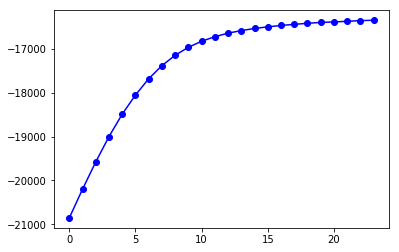

In [23]:
plt.plot(range(len(logL_hists[i])),logL_hists[i],'bo-')
plt.show()

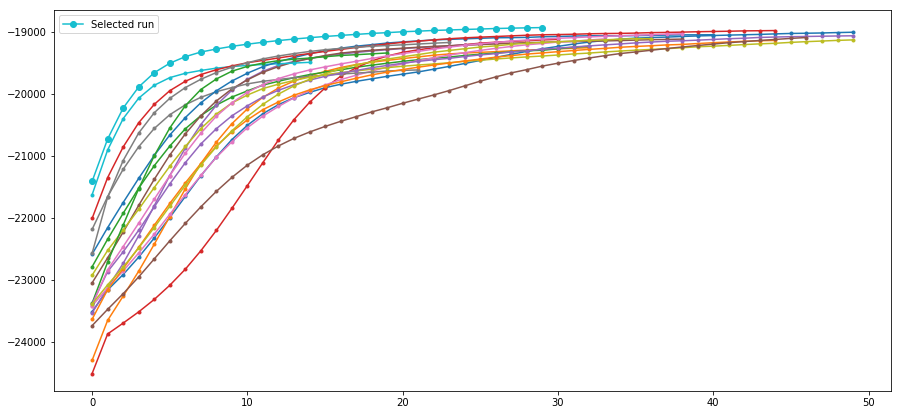

In [74]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [75]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [25]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.923077 |     0.923077 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.93895 |      0.93895 |
+----+--------+------------+--------------+


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [19]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7905759162303665


In [ ]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [ ]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [ ]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [26]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6202686202686203


*** Soft-Majority (Train with softMV) ***
Train


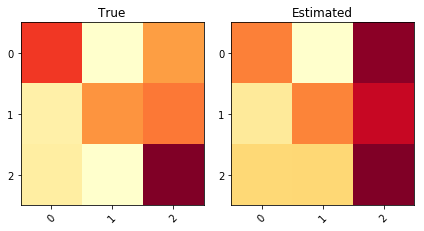

KL divergence: 0.1467	Pearson Correlation between diagonals: 0.9262


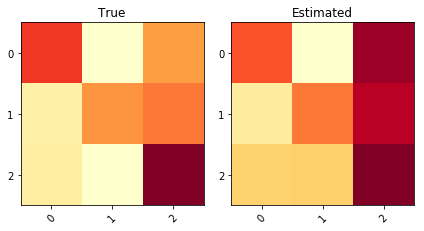

KL divergence: 0.1491	Pearson Correlation between diagonals: 0.9702


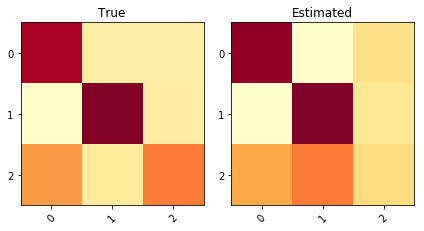

KL divergence: 0.1792	Pearson Correlation between diagonals: 0.9890


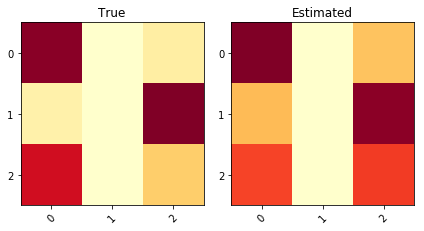

KL divergence: 0.0966	Pearson Correlation between diagonals: 0.9074


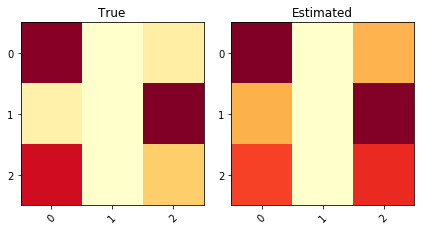

KL divergence: 0.1123	Pearson Correlation between diagonals: 0.8873


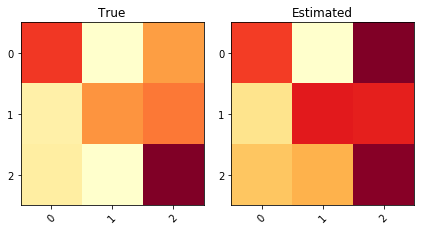

KL divergence: 0.1670	Pearson Correlation between diagonals: 0.7885


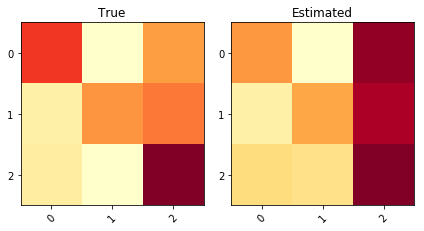

KL divergence: 0.1424	Pearson Correlation between diagonals: 0.9503


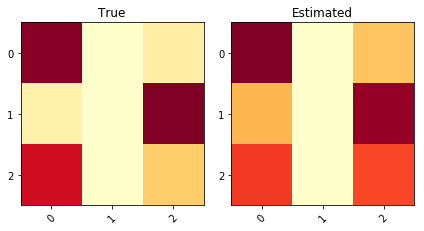

KL divergence: 0.0938	Pearson Correlation between diagonals: 0.9210


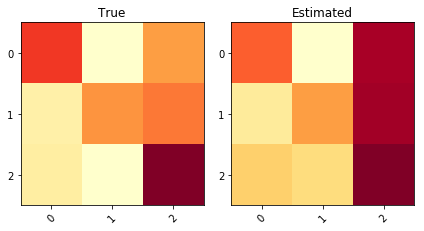

KL divergence: 0.1337	Pearson Correlation between diagonals: 0.9909


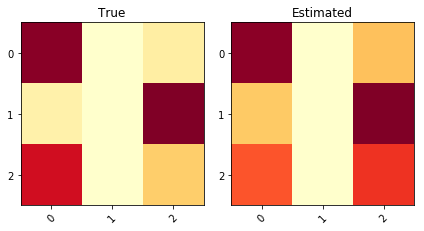

KL divergence: 0.0972	Pearson Correlation between diagonals: 0.8899


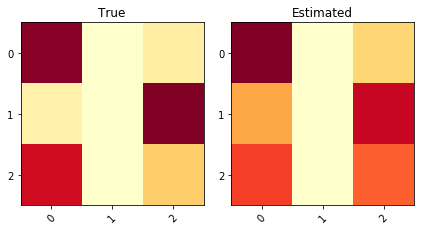

KL divergence: 0.0989	Pearson Correlation between diagonals: 0.9415


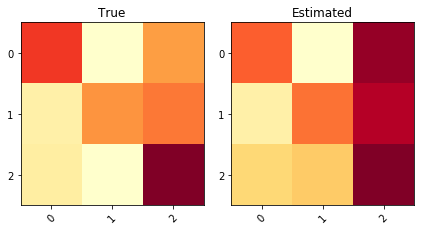

KL divergence: 0.1451	Pearson Correlation between diagonals: 0.9496


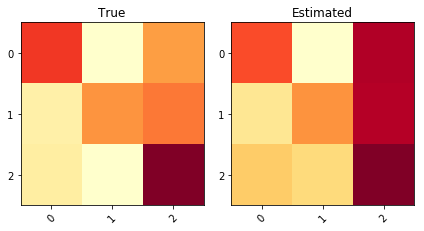

KL divergence: 0.1282	Pearson Correlation between diagonals: 0.9939


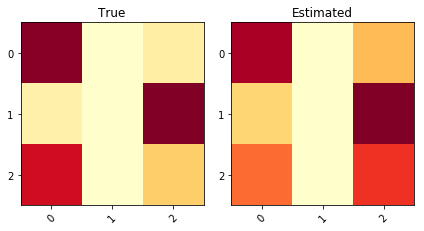

KL divergence: 0.1051	Pearson Correlation between diagonals: 0.8626


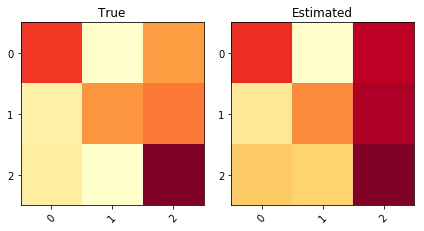

KL divergence: 0.1369	Pearson Correlation between diagonals: 1.0000
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.565731 |     0.565731 |     0.132365 |              0.944375 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.59707 |      0.59707 |
+----+--------+------------+--------------+


In [27]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


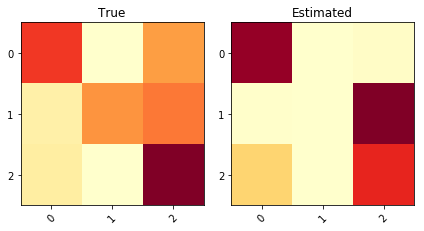

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6345


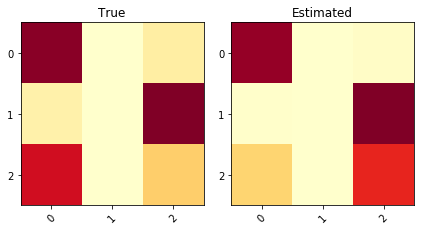

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8628


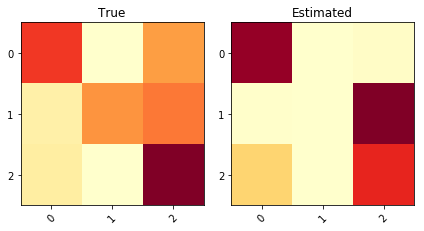

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6345


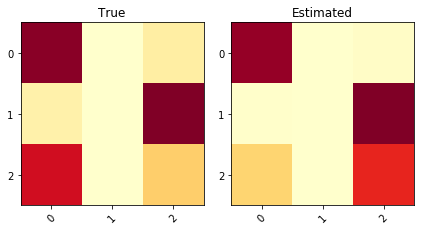

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8628


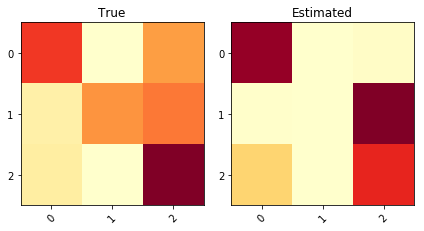

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6345


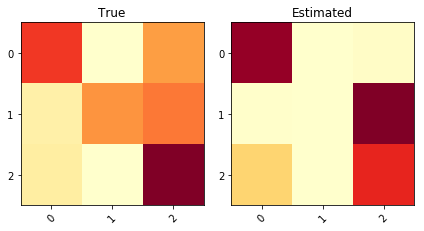

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6345


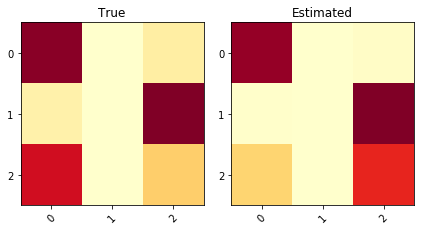

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8628


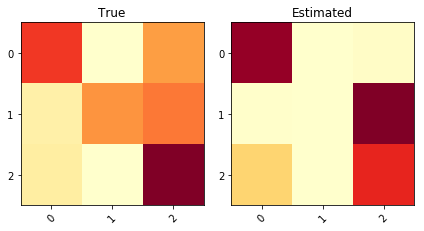

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6345


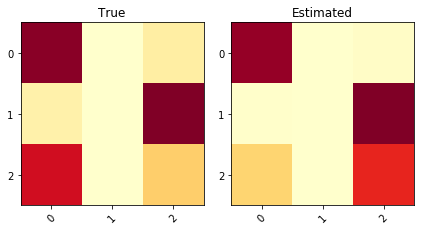

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8628


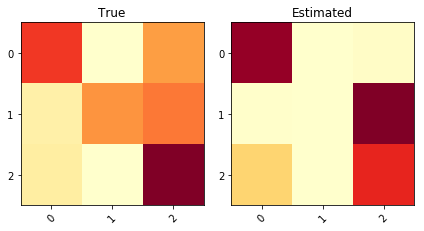

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6345


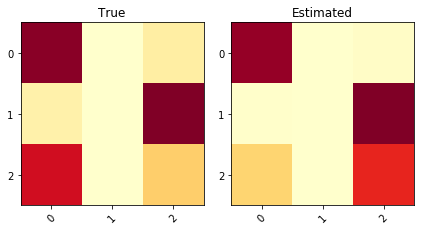

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8628


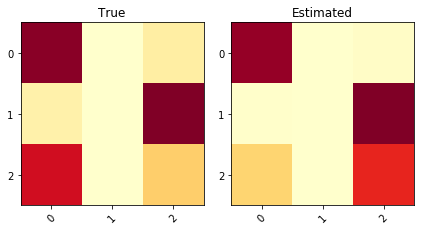

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8628


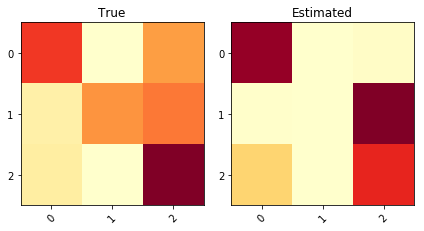

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6345


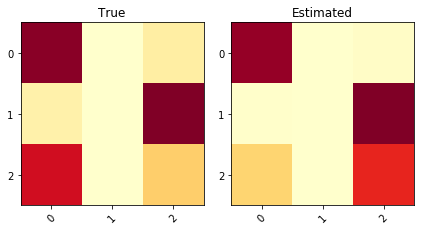

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8628


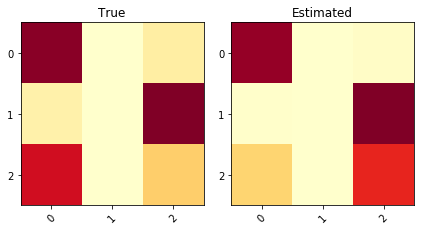

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8628
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.565731 |     0.565731 |      2.10296 |              0.549761 |
+----+--------+------------+--------------+--------------+-----------------------+


In [28]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


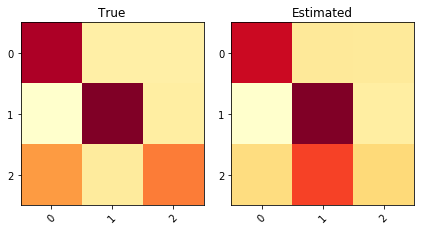

KL divergence: 0.1740	Pearson Correlation between diagonals: 0.9997


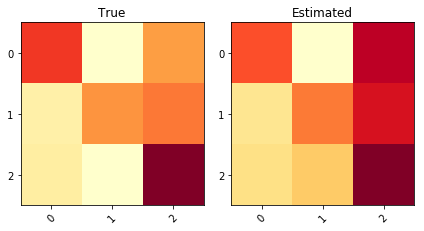

KL divergence: 0.1366	Pearson Correlation between diagonals: 0.9757


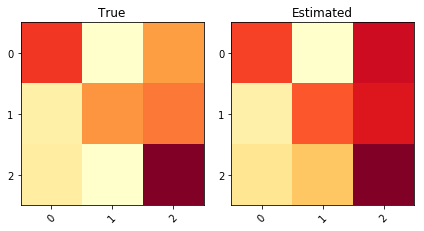

KL divergence: 0.1272	Pearson Correlation between diagonals: 0.9613


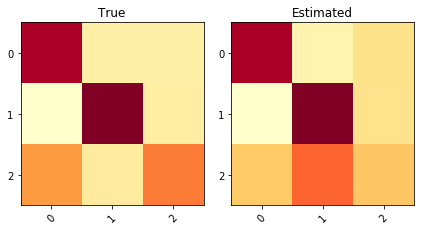

KL divergence: 0.1548	Pearson Correlation between diagonals: 0.9971


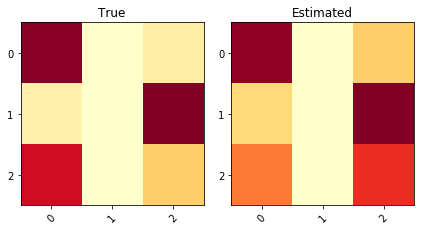

KL divergence: 0.0971	Pearson Correlation between diagonals: 0.8765


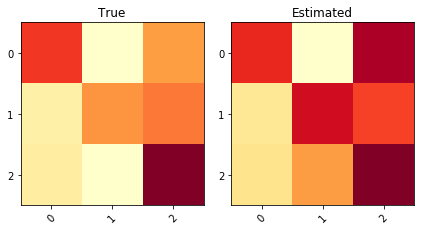

KL divergence: 0.1579	Pearson Correlation between diagonals: 0.7407


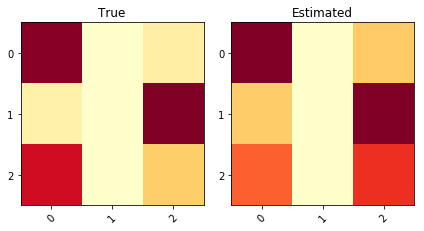

KL divergence: 0.0943	Pearson Correlation between diagonals: 0.8924


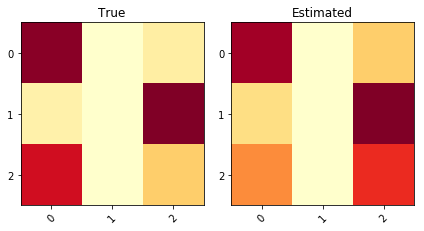

KL divergence: 0.1020	Pearson Correlation between diagonals: 0.8603


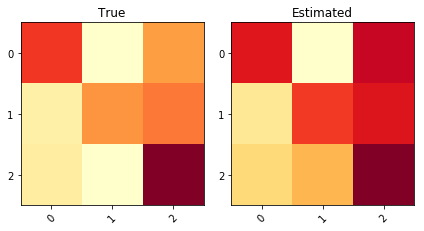

KL divergence: 0.1343	Pearson Correlation between diagonals: 0.9906


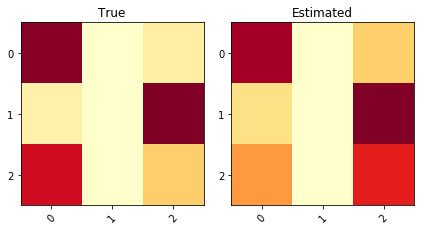

KL divergence: 0.1166	Pearson Correlation between diagonals: 0.8374


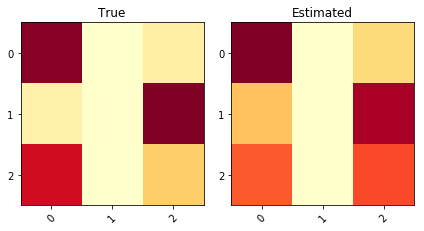

KL divergence: 0.0877	Pearson Correlation between diagonals: 0.9236


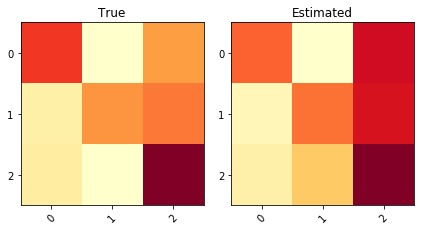

KL divergence: 0.1264	Pearson Correlation between diagonals: 0.9442


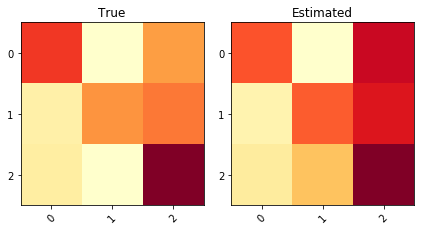

KL divergence: 0.1286	Pearson Correlation between diagonals: 0.9397


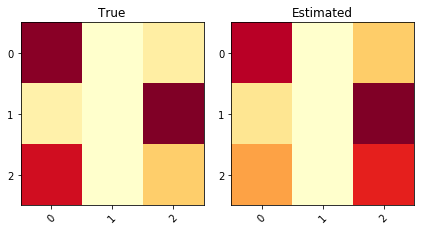

KL divergence: 0.1224	Pearson Correlation between diagonals: 0.8187


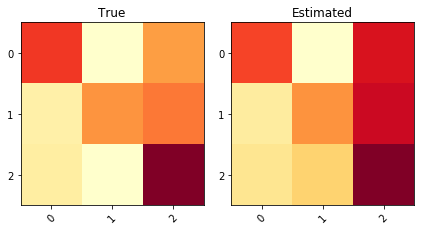

KL divergence: 0.1122	Pearson Correlation between diagonals: 0.9976
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.608873 |     0.608873 |     0.121597 |              0.930603 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.634921 |     0.634921 |
+----+--------+------------+--------------+


In [29]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


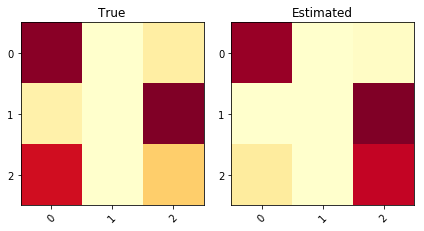

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7824


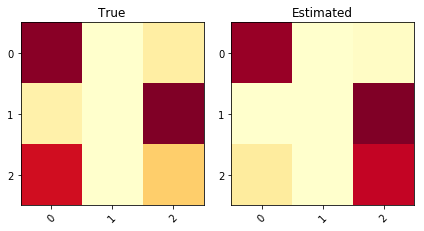

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7824


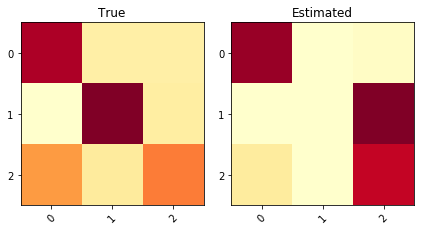

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.5869


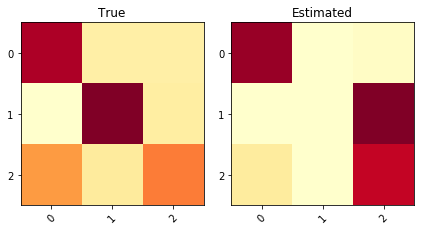

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.5869


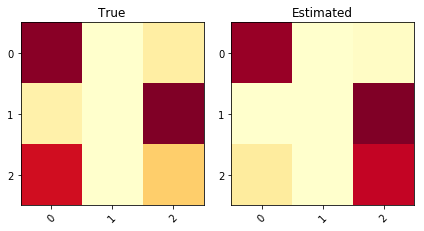

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7824


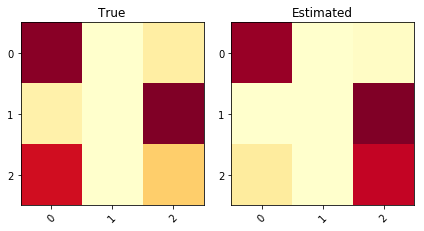

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7824


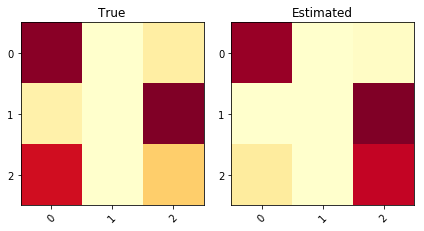

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7824


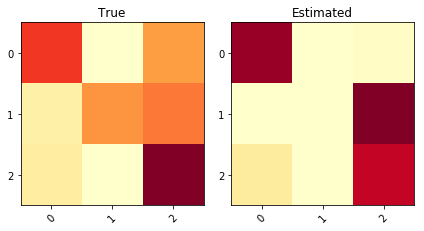

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.7378


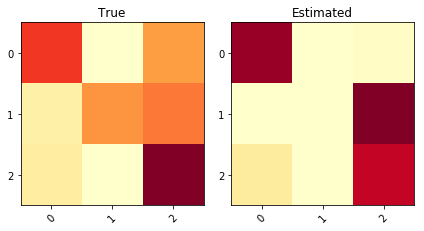

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.7378


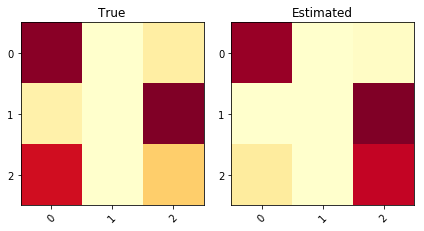

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7824


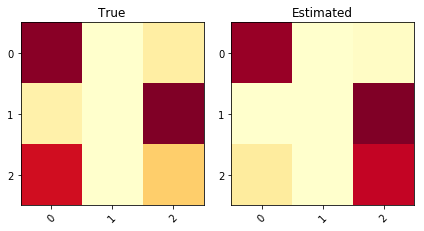

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7824


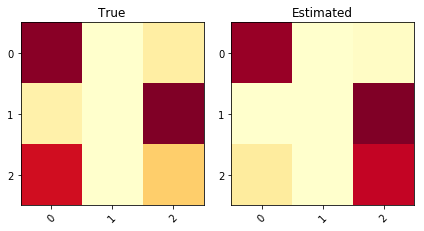

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7824


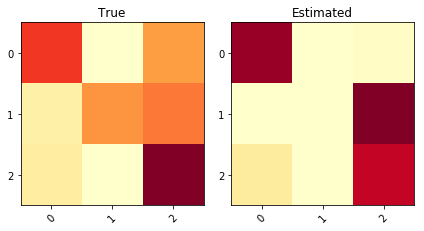

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.7378


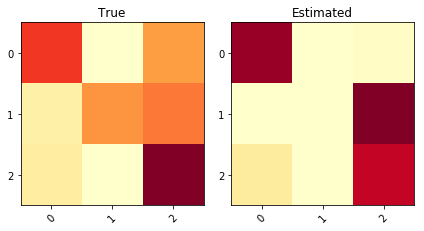

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.7378


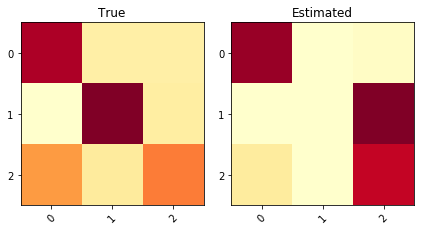

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.5869
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.608873 |     0.608873 |      2.10296 |              0.543674 |
+----+--------+------------+--------------+--------------+-----------------------+


In [30]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


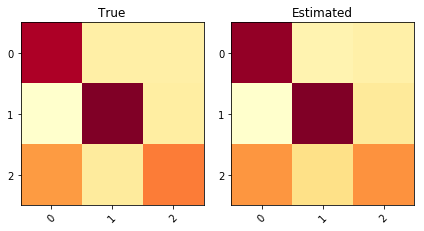

KL divergence: 0.0062	Pearson Correlation between diagonals: 0.9922


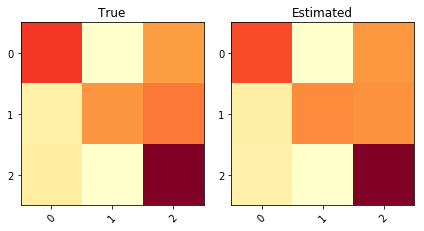

KL divergence: 0.0027	Pearson Correlation between diagonals: 0.9898


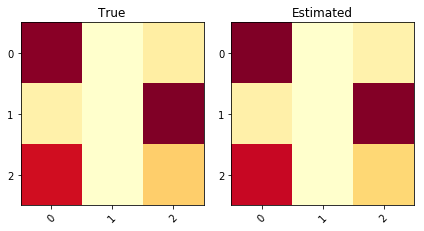

KL divergence: 0.0016	Pearson Correlation between diagonals: 0.9993


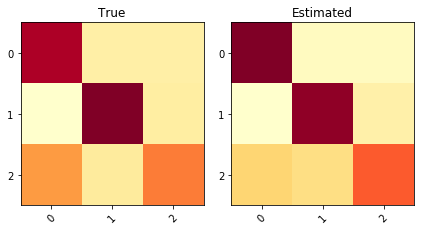

KL divergence: 0.0458	Pearson Correlation between diagonals: 0.9651


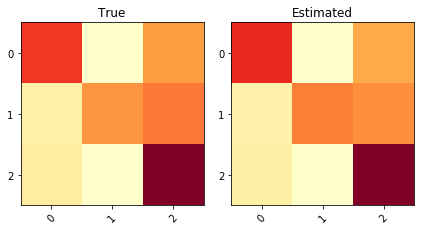

KL divergence: 0.0026	Pearson Correlation between diagonals: 1.0000


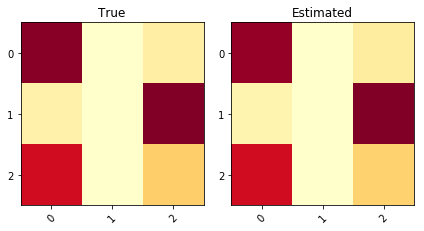

KL divergence: 0.0007	Pearson Correlation between diagonals: 1.0000


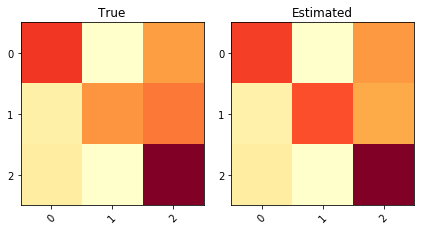

KL divergence: 0.0127	Pearson Correlation between diagonals: 0.9558


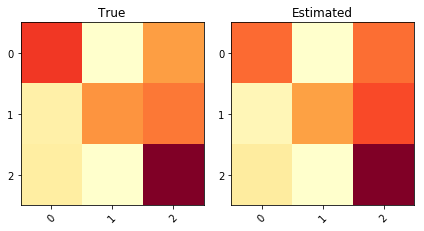

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9858


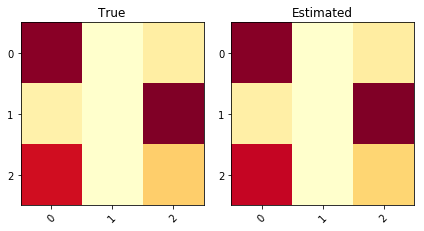

KL divergence: 0.0007	Pearson Correlation between diagonals: 0.9997


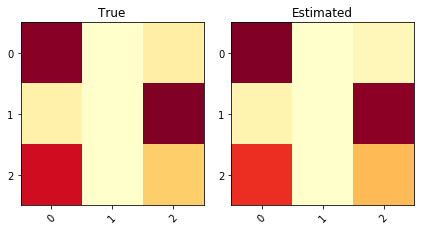

KL divergence: 0.0131	Pearson Correlation between diagonals: 0.9978


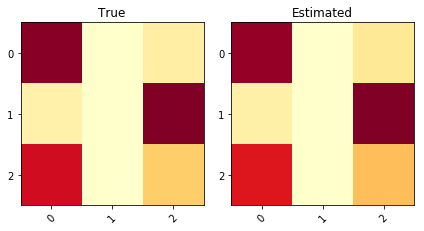

KL divergence: 0.0030	Pearson Correlation between diagonals: 0.9977


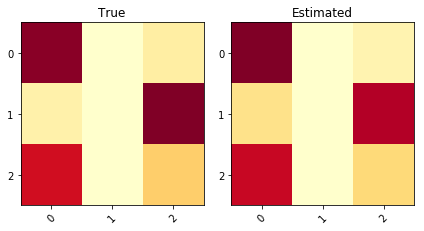

KL divergence: 0.0142	Pearson Correlation between diagonals: 0.9986


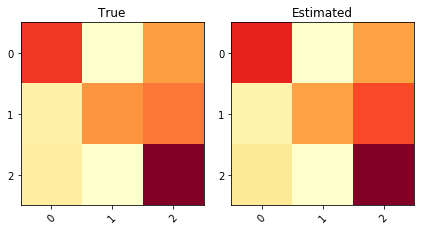

KL divergence: 0.0044	Pearson Correlation between diagonals: 0.9879


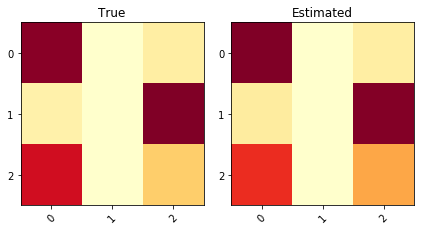

KL divergence: 0.0105	Pearson Correlation between diagonals: 0.9907


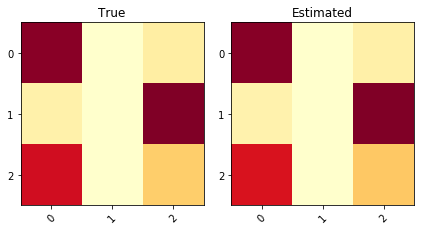

KL divergence: 0.0005	Pearson Correlation between diagonals: 0.9997
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.935694 |     0.935694 |    0.0164076 |              0.991332 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.95116 |      0.95116 |
+----+--------+------------+--------------+


In [31]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


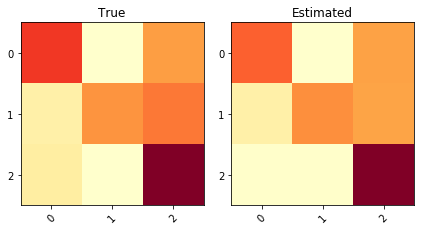

KL divergence: 0.0466	Pearson Correlation between diagonals: 0.9762


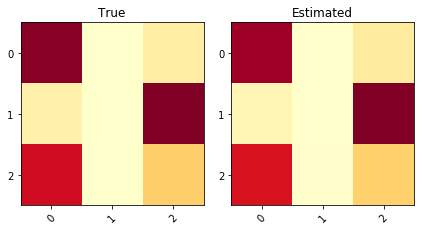

KL divergence: 0.0136	Pearson Correlation between diagonals: 1.0000


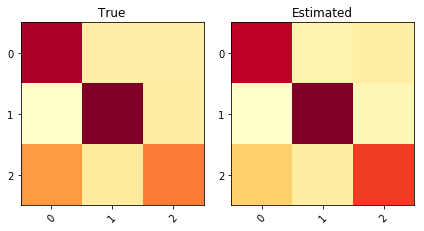

KL divergence: 0.0230	Pearson Correlation between diagonals: 0.9738


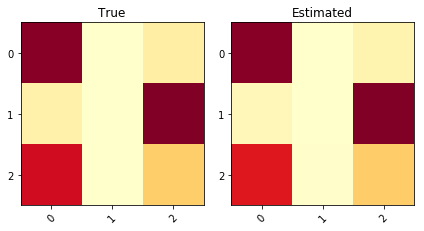

KL divergence: 0.0152	Pearson Correlation between diagonals: 1.0000


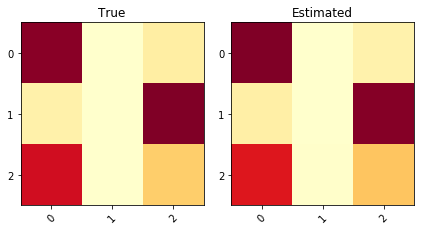

KL divergence: 0.0140	Pearson Correlation between diagonals: 0.9996


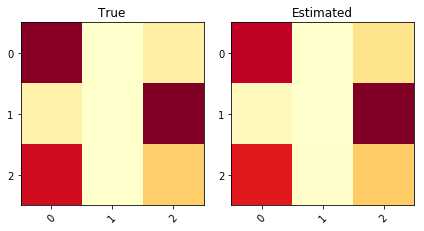

KL divergence: 0.0236	Pearson Correlation between diagonals: 0.9985


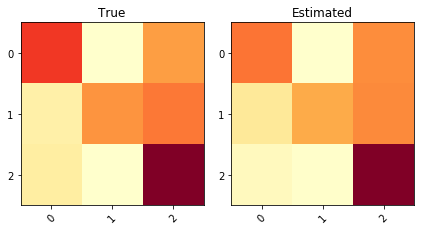

KL divergence: 0.0262	Pearson Correlation between diagonals: 0.9886


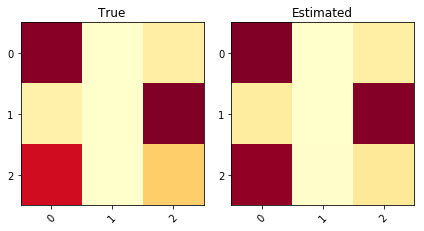

KL divergence: 0.0294	Pearson Correlation between diagonals: 0.9890


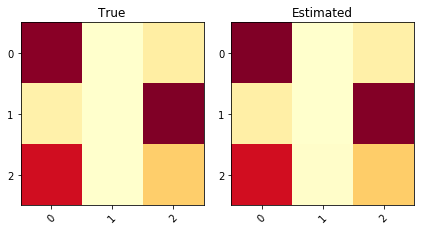

KL divergence: 0.0136	Pearson Correlation between diagonals: 1.0000


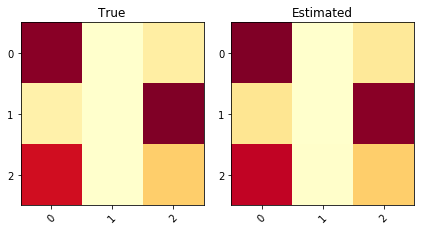

KL divergence: 0.0191	Pearson Correlation between diagonals: 1.0000


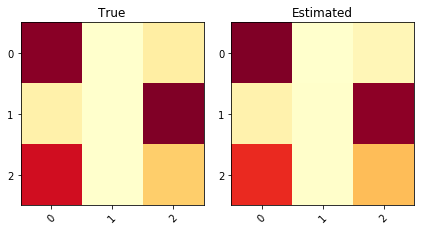

KL divergence: 0.0198	Pearson Correlation between diagonals: 0.9987


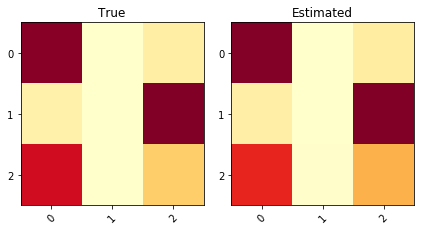

KL divergence: 0.0192	Pearson Correlation between diagonals: 0.9952


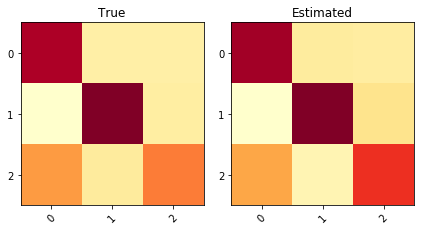

KL divergence: 0.0198	Pearson Correlation between diagonals: 0.9995


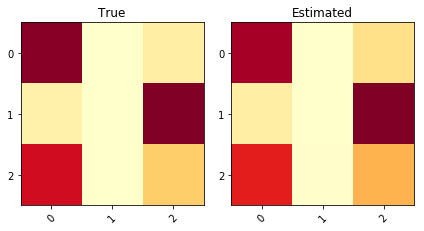

KL divergence: 0.0252	Pearson Correlation between diagonals: 0.9926


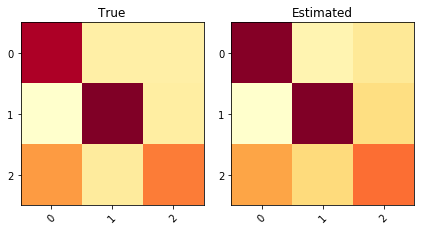

KL divergence: 0.0237	Pearson Correlation between diagonals: 0.9863
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.786732 |     0.786732 |    0.0194302 |              0.988401 |       0.241755 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.737656 |               0.604965 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+----

In [76]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


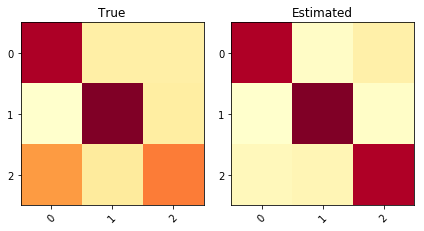

KL divergence: 0.2333	Pearson Correlation between diagonals: 0.6621


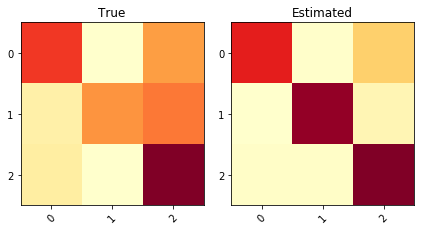

KL divergence: 0.3250	Pearson Correlation between diagonals: 0.2719


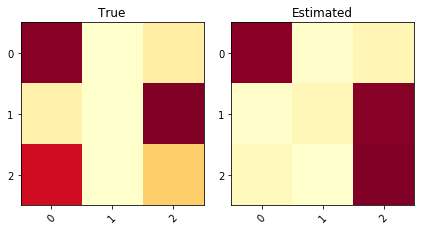

KL divergence: 0.6400	Pearson Correlation between diagonals: 0.7070


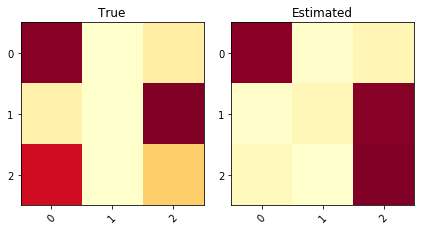

KL divergence: 0.6400	Pearson Correlation between diagonals: 0.7070


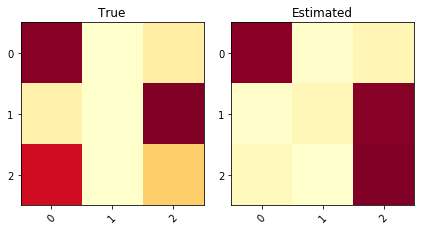

KL divergence: 0.6400	Pearson Correlation between diagonals: 0.7070


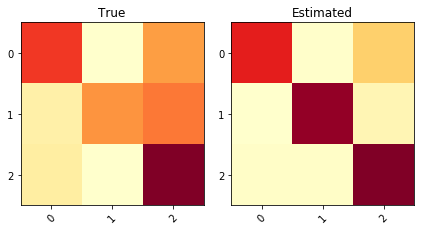

KL divergence: 0.3250	Pearson Correlation between diagonals: 0.2719


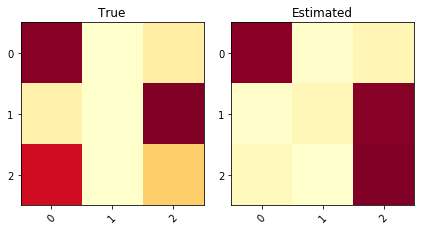

KL divergence: 0.6400	Pearson Correlation between diagonals: 0.7070


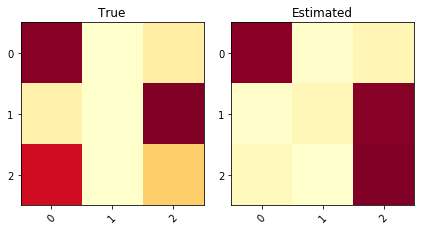

KL divergence: 0.6400	Pearson Correlation between diagonals: 0.7070


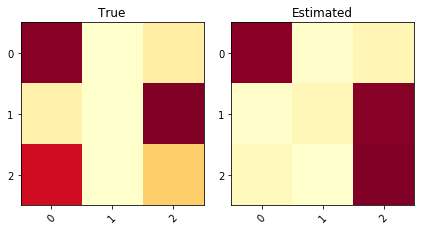

KL divergence: 0.6400	Pearson Correlation between diagonals: 0.7070


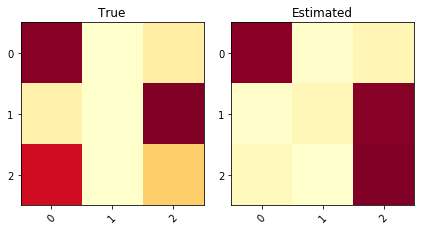

KL divergence: 0.6400	Pearson Correlation between diagonals: 0.7070


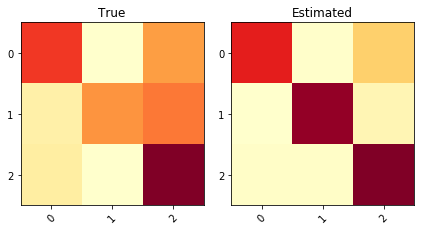

KL divergence: 0.3250	Pearson Correlation between diagonals: 0.2719


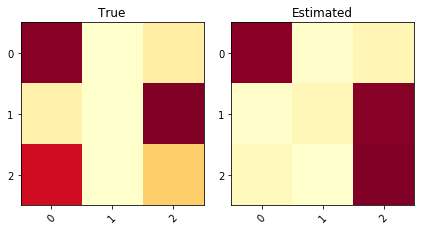

KL divergence: 0.6400	Pearson Correlation between diagonals: 0.7070


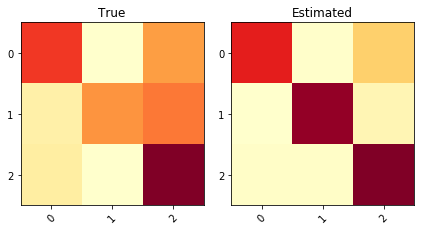

KL divergence: 0.3250	Pearson Correlation between diagonals: 0.2719


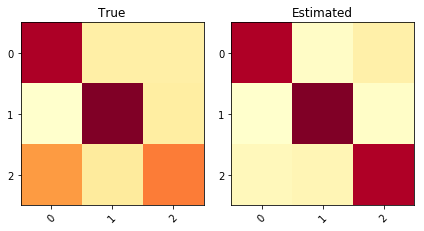

KL divergence: 0.2333	Pearson Correlation between diagonals: 0.6621


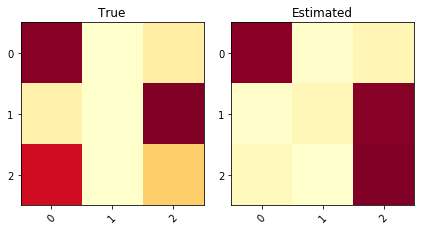

KL divergence: 0.6400	Pearson Correlation between diagonals: 0.7070
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.645096 |     0.645096 |     0.464176 |              0.567457 |       0.233844 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.725122 |                0.63545 |
+----+-------------------------+------------------------+
Test


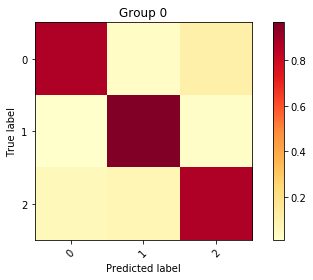

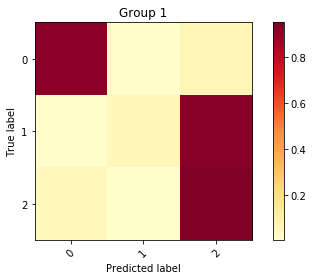

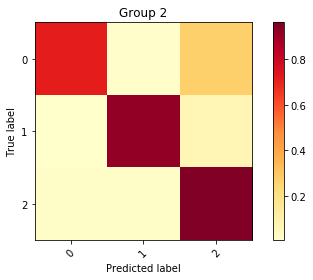

Inertia: 0.12157888539756338
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.215512 |     21 |  0.367225 |    0.901457 |  0.104975 |           0.948463 |   0.669109 |     0.669109 |
|  1 |        1 | 0.445431 |     44 |  0.252262 |    0.64478  |  1.00548  |           0.698297 |   0.443223 |     0.443223 |
|  2 |        2 | 0.339058 |     33 |  0.383722 |    0.864164 |  0.154477 |           0.925727 |   0.787546 |     0.787546 |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F

In [77]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


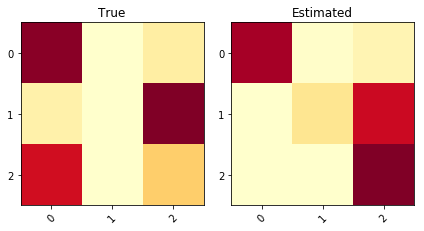

KL divergence: 1.2213	Pearson Correlation between diagonals: 0.6598


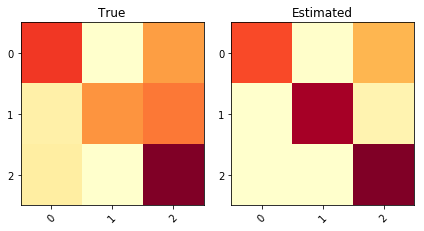

KL divergence: 0.3735	Pearson Correlation between diagonals: 0.3346


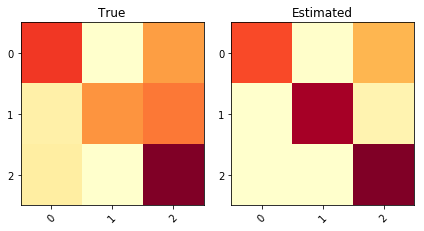

KL divergence: 0.3735	Pearson Correlation between diagonals: 0.3346


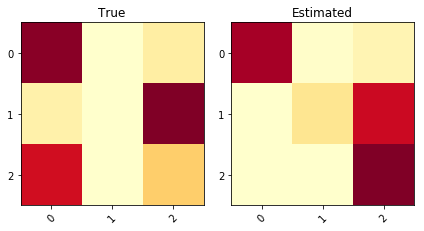

KL divergence: 1.2213	Pearson Correlation between diagonals: 0.6598


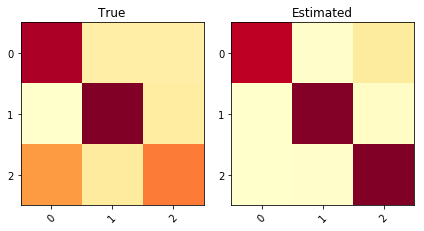

KL divergence: 0.5624	Pearson Correlation between diagonals: -0.3834


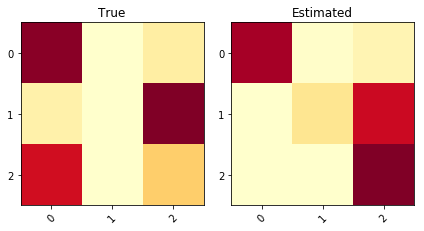

KL divergence: 1.2213	Pearson Correlation between diagonals: 0.6598


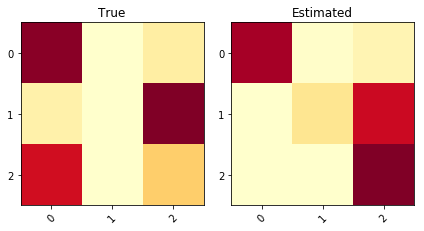

KL divergence: 1.2213	Pearson Correlation between diagonals: 0.6598


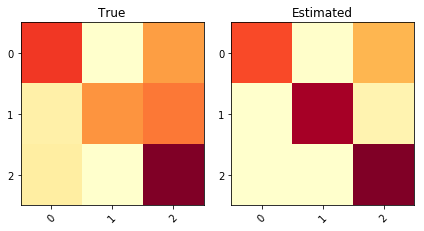

KL divergence: 0.3735	Pearson Correlation between diagonals: 0.3346


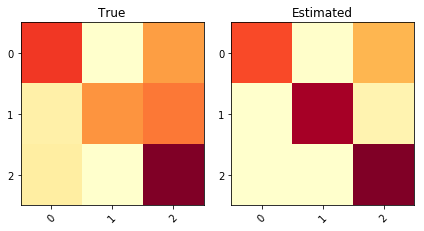

KL divergence: 0.3735	Pearson Correlation between diagonals: 0.3346


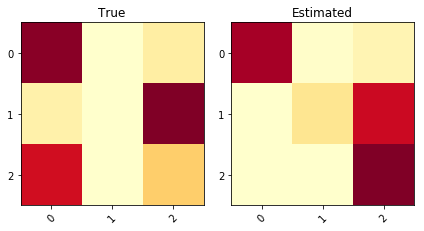

KL divergence: 1.2213	Pearson Correlation between diagonals: 0.6598


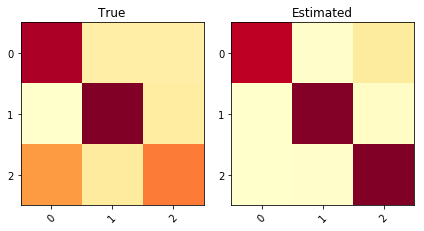

KL divergence: 0.5624	Pearson Correlation between diagonals: -0.3834


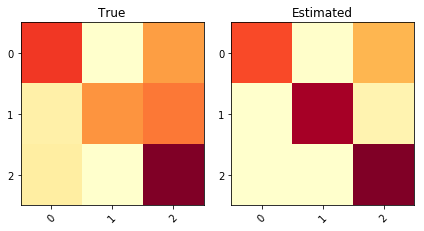

KL divergence: 0.3735	Pearson Correlation between diagonals: 0.3346


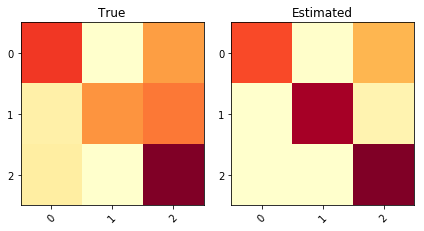

KL divergence: 0.3735	Pearson Correlation between diagonals: 0.3346


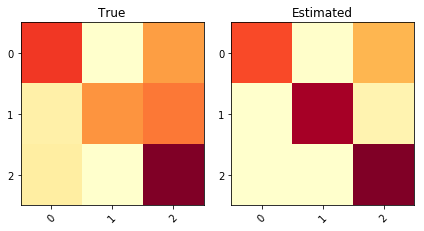

KL divergence: 0.3735	Pearson Correlation between diagonals: 0.3346


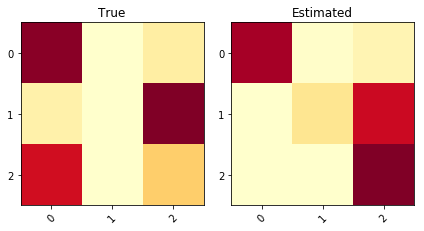

KL divergence: 1.2213	Pearson Correlation between diagonals: 0.6598
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.631665 |     0.631665 |     0.691063 |              0.298317 |       0.152981 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.664314 |                0.69319 |
+----+-------------------------+------------------------+
Test


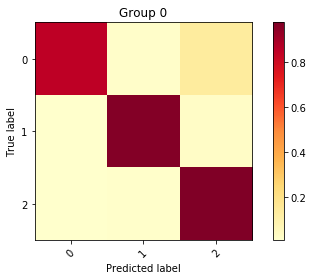

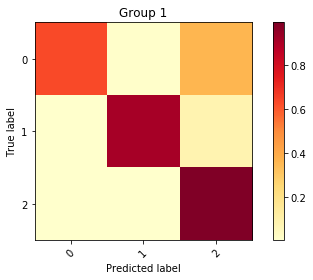

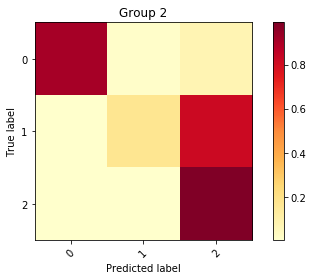

Inertia: 0.09113043469066422
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.213686 |     21 |  0.251431 |    0.931925 | 0.0725205 |           0.964402 |   0.770452 |     0.770452 |
|  1 |        1 | 0.508677 |     50 |  0.350009 |    0.845909 | 0.185733  |           0.912412 |   0.702076 |     0.702076 |
|  2 |        2 | 0.277637 |     27 |  0.296613 |    0.692146 | 0.618455  |           0.768058 |   0.58486  |     0.58486  |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F

In [17]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


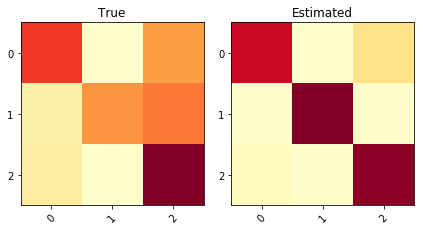

KL divergence: 0.4660	Pearson Correlation between diagonals: -0.0273


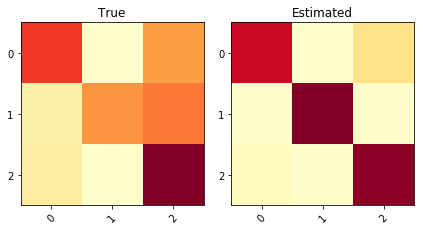

KL divergence: 0.4660	Pearson Correlation between diagonals: -0.0273


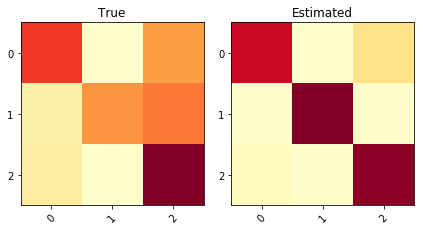

KL divergence: 0.4661	Pearson Correlation between diagonals: -0.0273


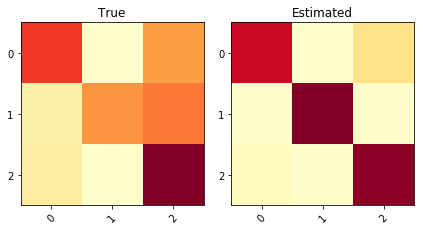

KL divergence: 0.4660	Pearson Correlation between diagonals: -0.0272


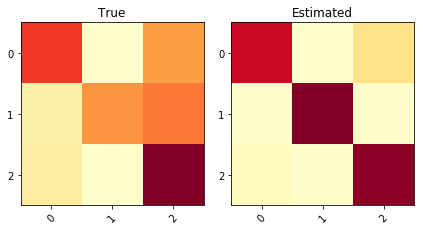

KL divergence: 0.4660	Pearson Correlation between diagonals: -0.0272


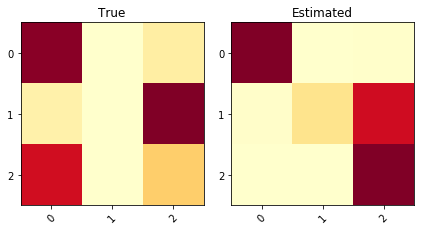

KL divergence: 1.1551	Pearson Correlation between diagonals: 0.7215


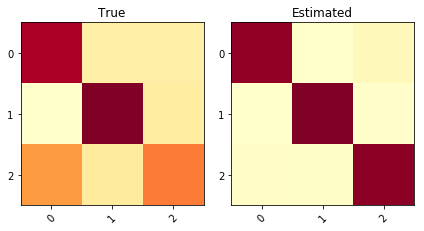

KL divergence: 0.4621	Pearson Correlation between diagonals: 0.4232


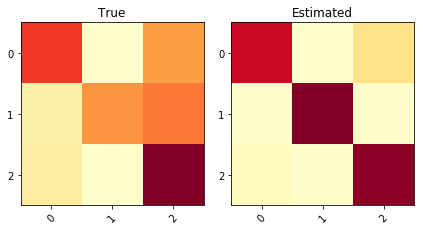

KL divergence: 0.4672	Pearson Correlation between diagonals: -0.0281


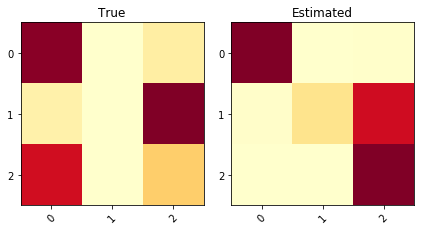

KL divergence: 1.1551	Pearson Correlation between diagonals: 0.7215


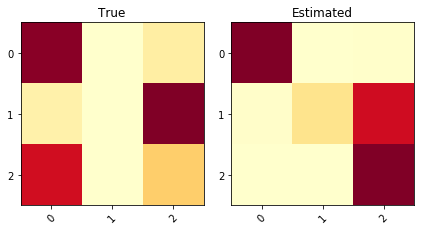

KL divergence: 1.1551	Pearson Correlation between diagonals: 0.7215


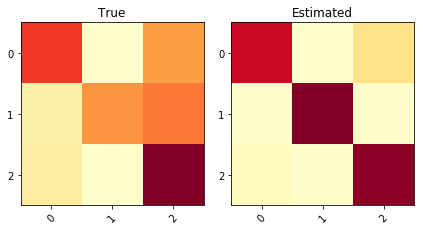

KL divergence: 0.4662	Pearson Correlation between diagonals: -0.0274


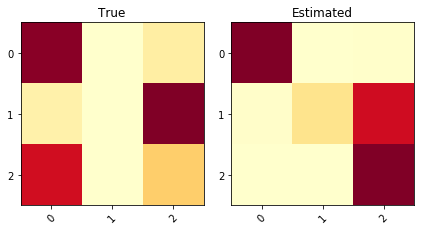

KL divergence: 1.1551	Pearson Correlation between diagonals: 0.7215


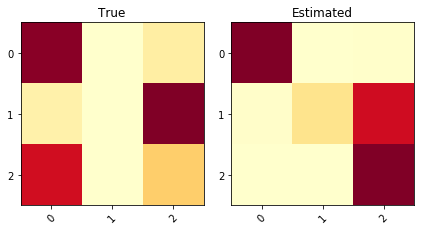

KL divergence: 1.1551	Pearson Correlation between diagonals: 0.7215


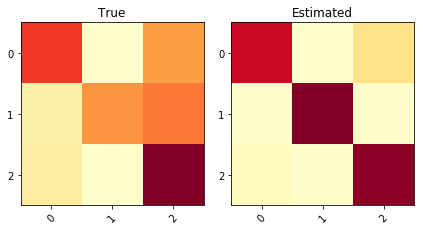

KL divergence: 0.4672	Pearson Correlation between diagonals: -0.0281


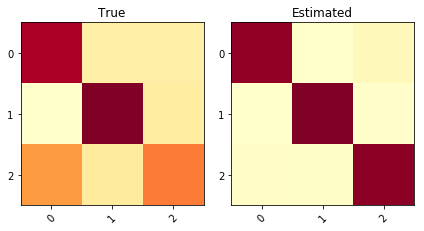

KL divergence: 0.4616	Pearson Correlation between diagonals: 0.4185
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.865283 |     0.865283 |     0.691646 |              0.309789 |       0.125673 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.665329 |               0.723908 |
+----+-------------------------+------------------------+
Test


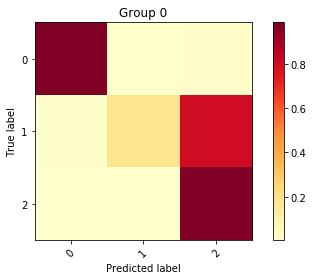

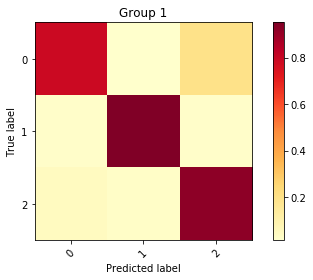

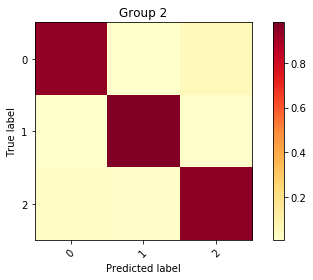

Inertia: 0.1000481303781271
A result
 +----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
|    |   Groups |     Prob |   T(g) |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |   Accuracy |   F1 (micro) |
|----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------|
|  0 |        0 | 0.449697 |     44 |  0.238391 |    0.717374 | 0.579447  |           0.783461 |   0.62149  |     0.62149  |
|  1 |        1 | 0.140685 |     14 |  0.371696 |    0.888001 | 0.122189  |           0.940461 |   0.919414 |     0.919414 |
|  2 |        2 | 0.409619 |     40 |  0.184101 |    0.960043 | 0.0409175 |           0.979679 |   0.89011  |     0.89011  |
+----+----------+----------+--------+-----------+-------------+-----------+--------------------+------------+--------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1

In [18]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [45]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.81282722513089


In [ ]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [ ]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [ ]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 20 )

In [112]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8538394415357766


In [ ]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [ ]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [ ]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 5) configuration: Manny annot v2 ($T=5000, T_{data}=40$)

#### 6) configuration: Manny annot v3 ($T$ = 10000, $T_{data}$ = 40 )

In [98]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.9101221640488656


In [ ]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [ ]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [ ]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v1 bad MV ($T$ = 2000, $T_{max}$ = 20 )

In [37]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6295811518324608
